In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [2]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [3]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [4]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200406,AK,191.0,6692.0,NaN,NaN,23.0,NaN,NaN,NaN,...,23.0,6883,6883,6883,02,0.0,3.0,593.0,6.0,599.0
1,20200406,AL,1968.0,12797.0,NaN,NaN,240.0,NaN,NaN,NaN,...,240.0,14765,14765,14765,01,5.0,9.0,1515.0,172.0,1687.0
2,20200406,AR,875.0,11970.0,NaN,74.0,130.0,NaN,43.0,22.0,...,130.0,12845,12845,12845,05,0.0,0.0,1558.0,45.0,1603.0
3,20200406,AS,0.0,20.0,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,31,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200406,AZ,2456.0,30078.0,NaN,NaN,325.0,NaN,112.0,NaN,...,325.0,32534,32534,32534,04,1.0,15.0,4937.0,187.0,5124.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,20200304,OR,3.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,50,32,32,41,NaN,NaN,NaN,NaN,NaN
1761,20200304,SC,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5,5,5,45,NaN,NaN,NaN,NaN,NaN
1762,20200304,TX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,48,NaN,NaN,NaN,NaN,NaN
1763,20200304,WA,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,39,39,39,53,NaN,NaN,NaN,NaN,NaN


In [5]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [6]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [7]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [8]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [9]:
tests_df.groupby('Date')['completed'].sum().max()

1917095.0

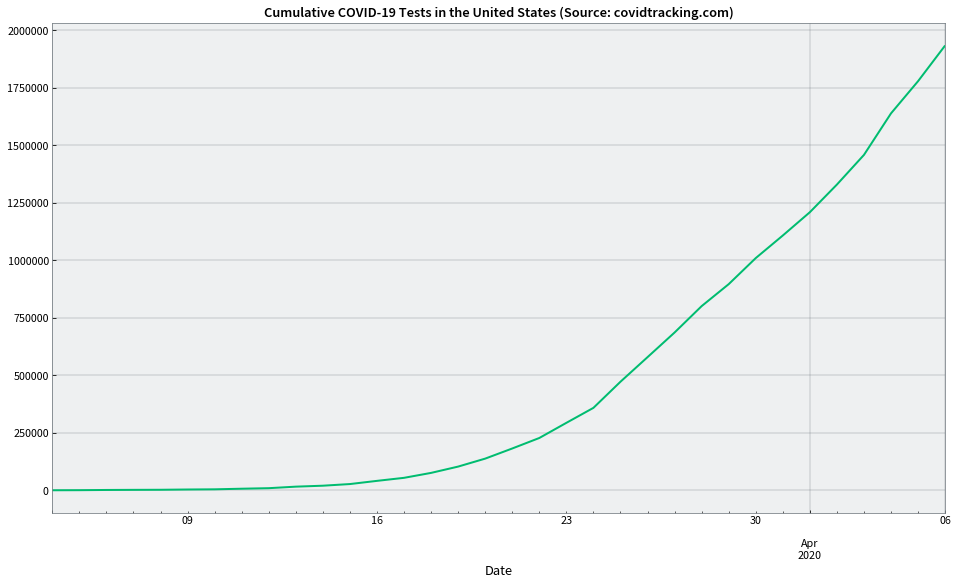

In [10]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

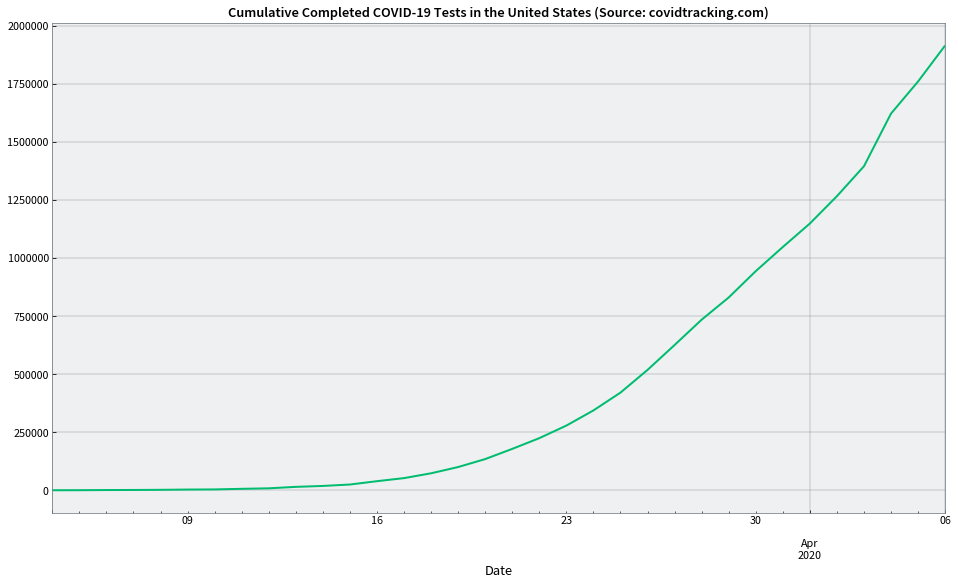

In [11]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

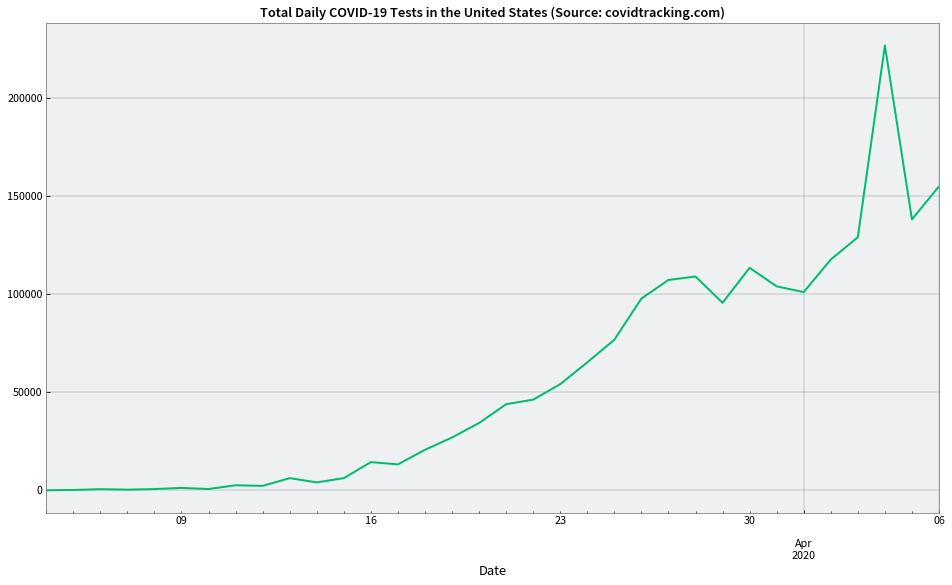

In [43]:
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', 
                                                    title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")

In [13]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

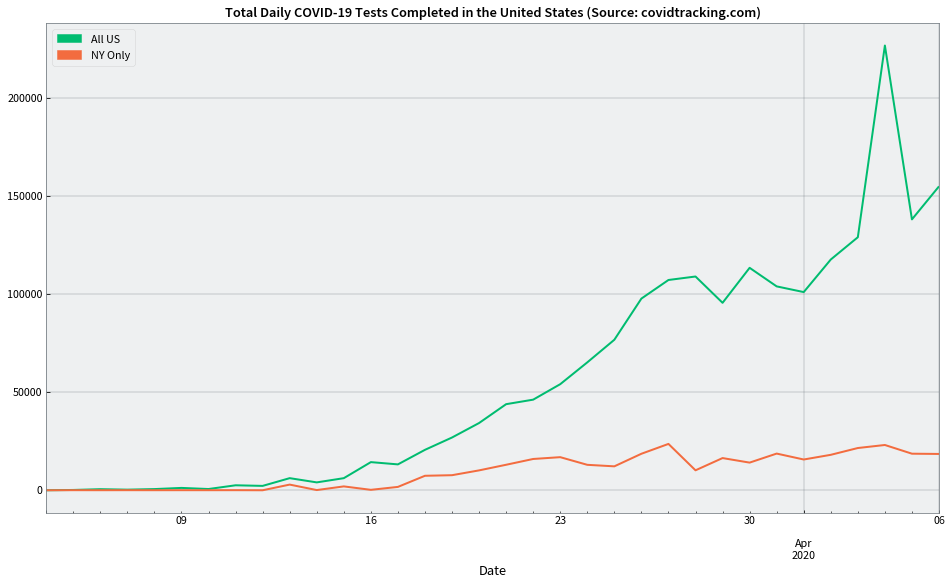

In [14]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [15]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

117167.35714285714

In [16]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

17323.0

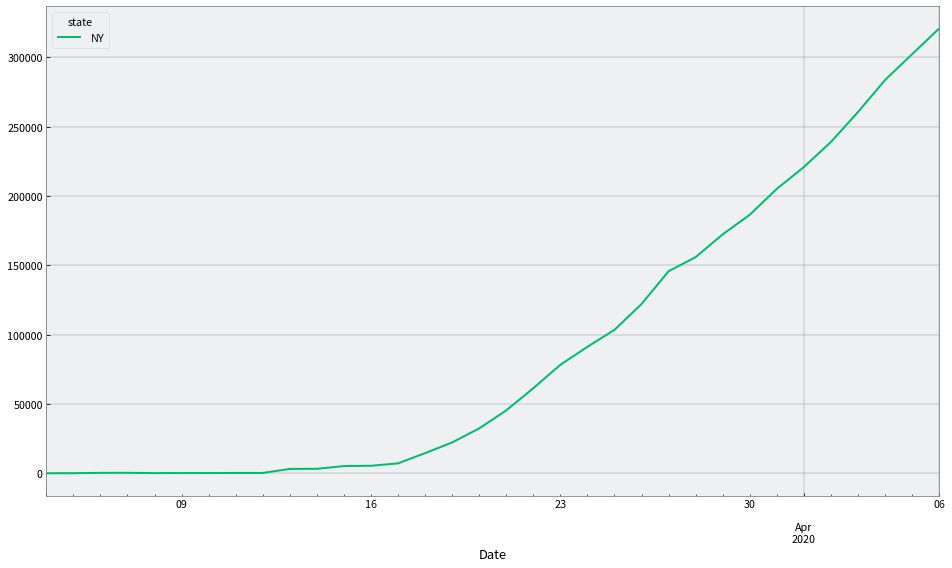

In [17]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

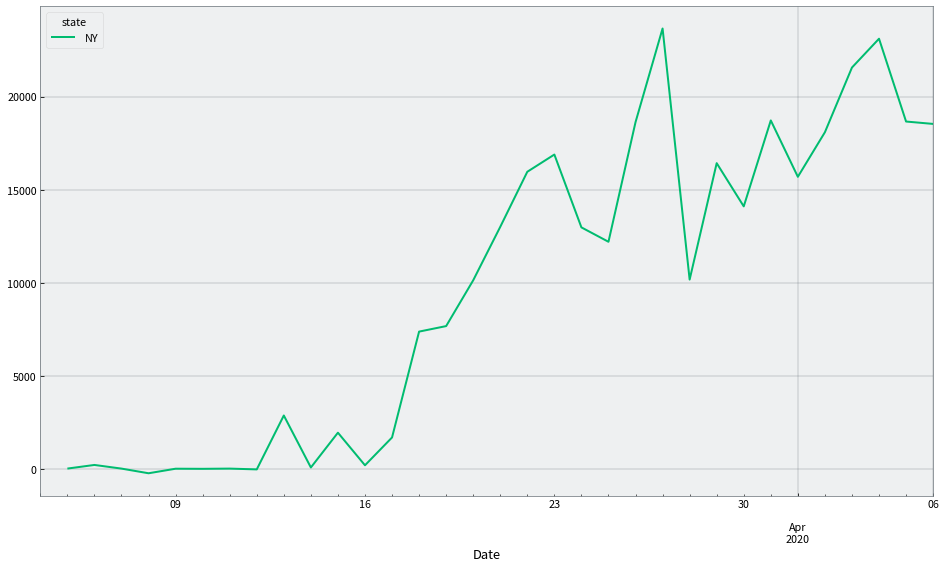

In [18]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line')

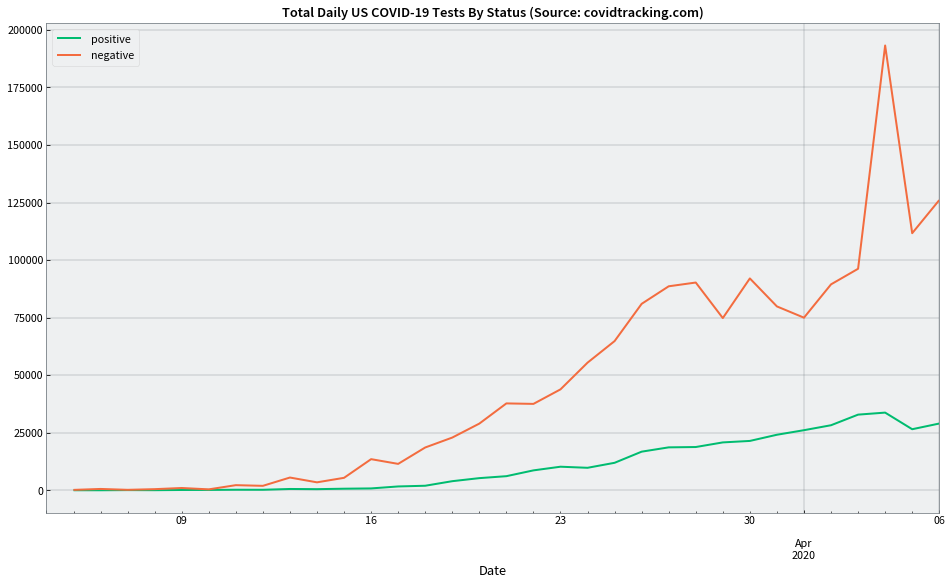

In [19]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

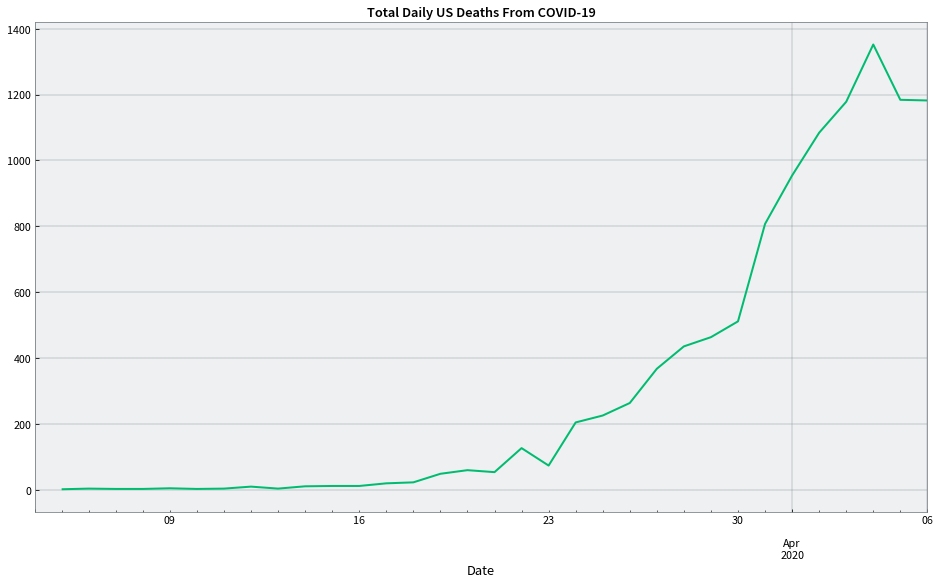

In [20]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

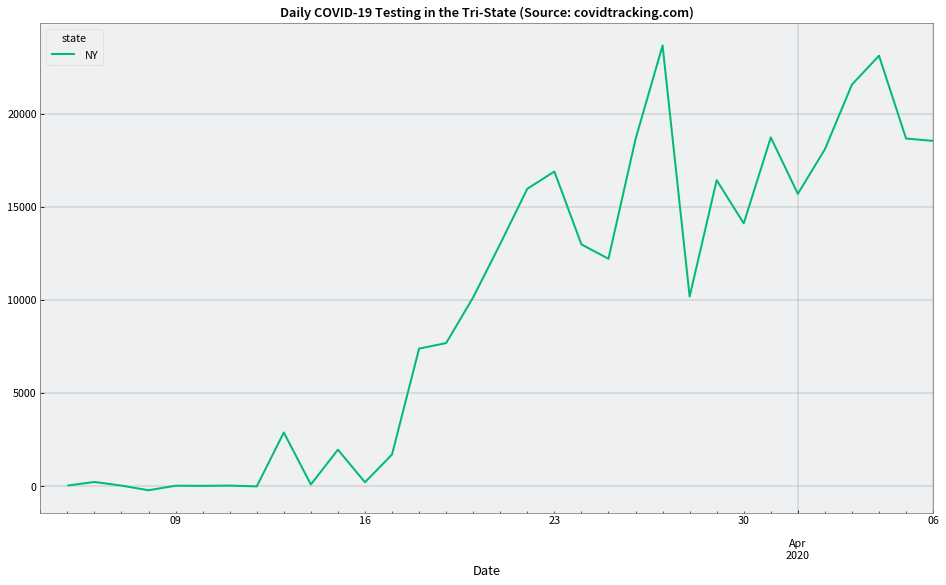

In [21]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

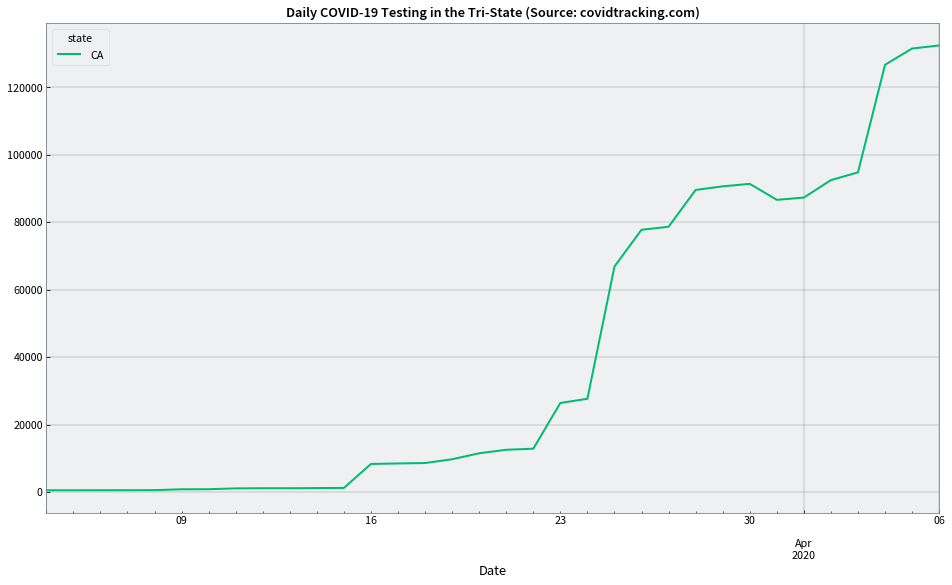

In [22]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

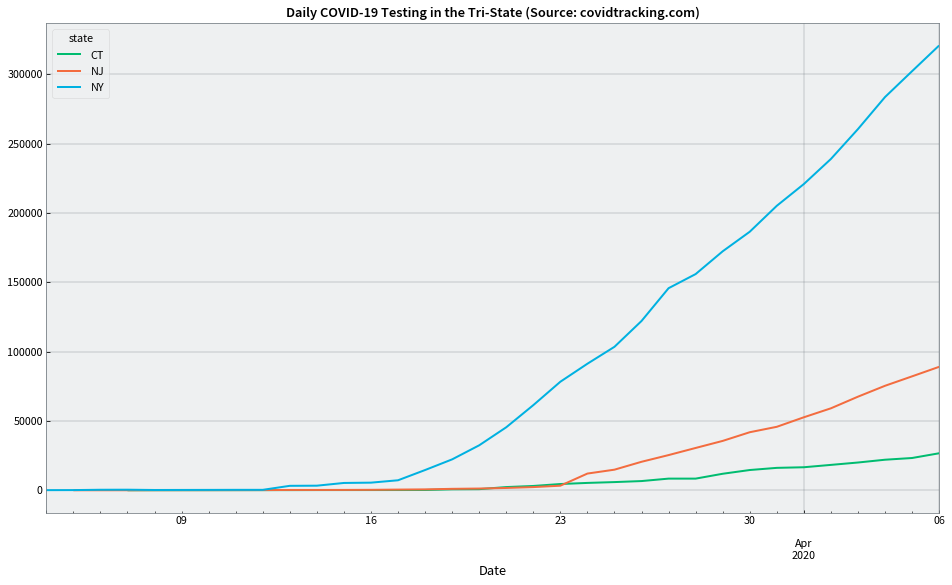

In [23]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

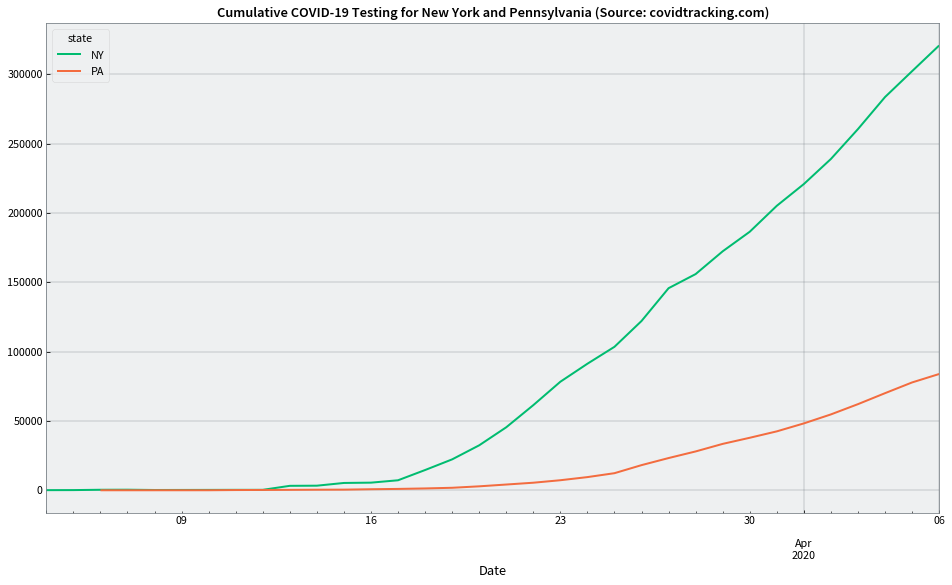

In [24]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

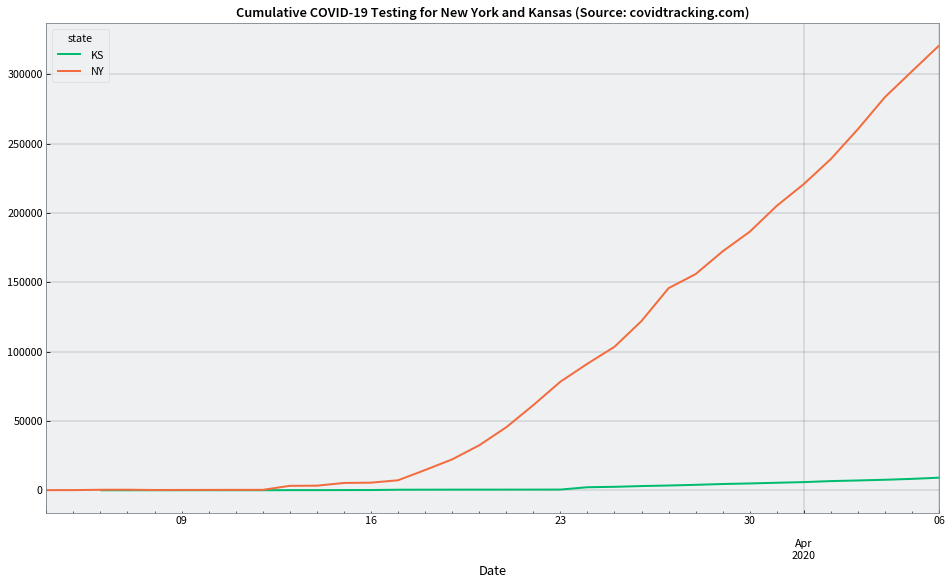

In [25]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

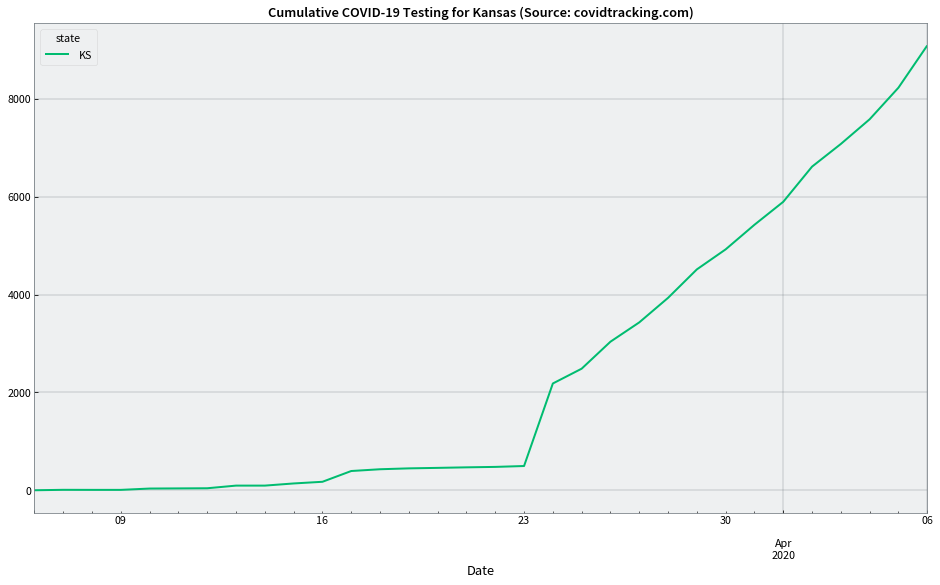

In [26]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [27]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

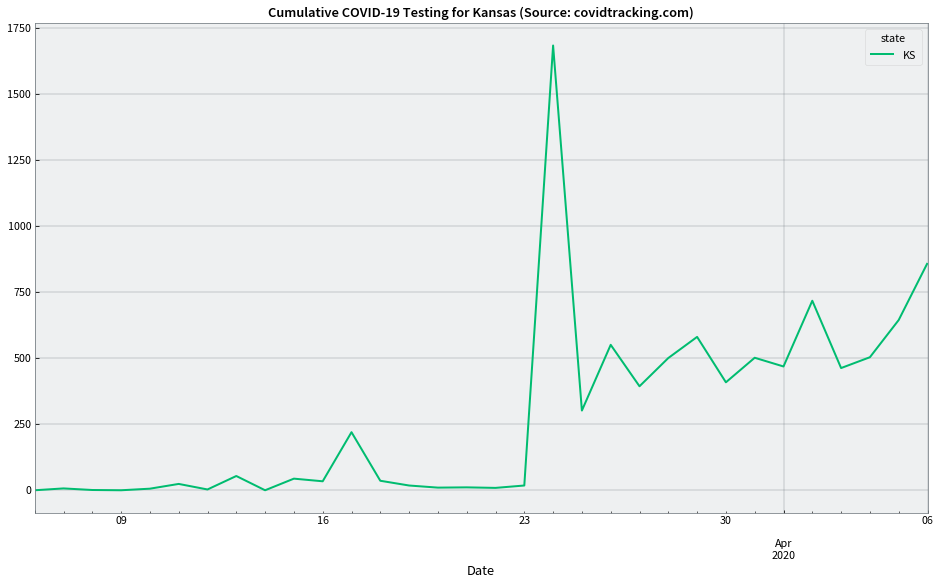

In [28]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

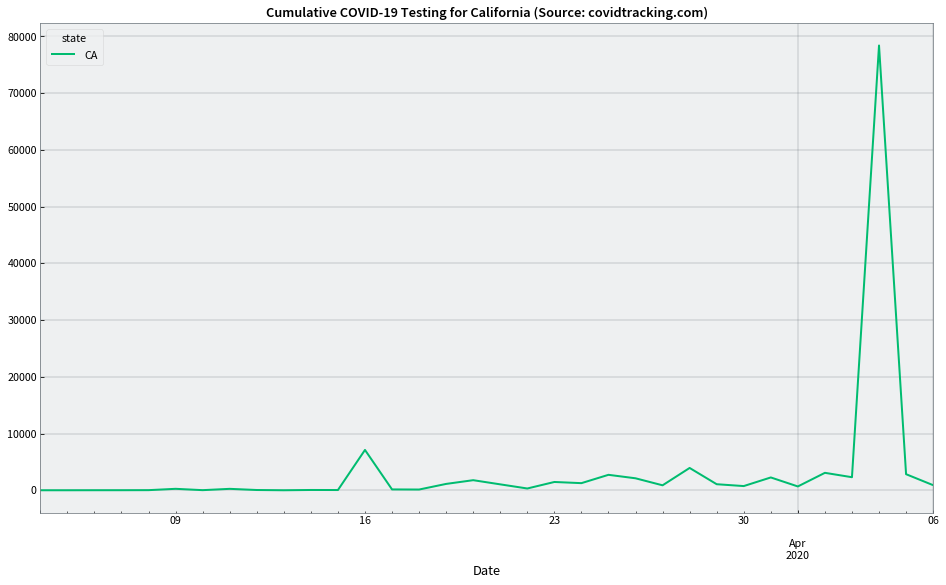

In [29]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

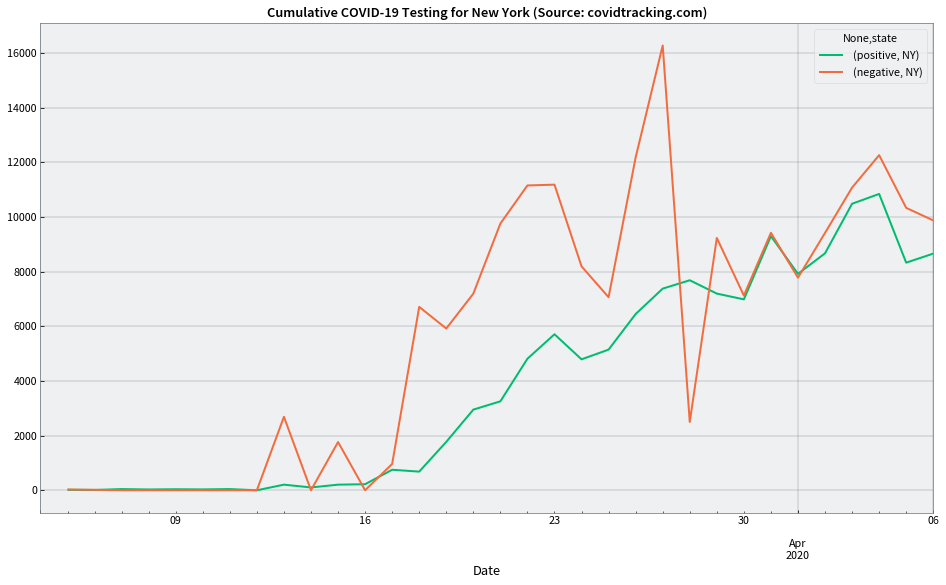

In [30]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [31]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

In [32]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
2020-04-03    9.095655
2020-04-04    9.302203
2020-04-05    9.293370
2020-04-06    9.414577
dtype: float64

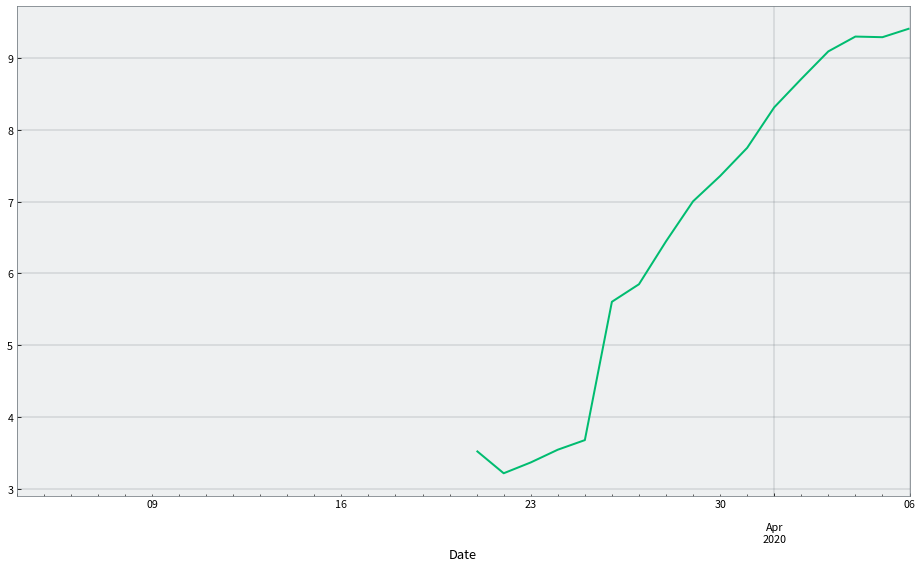

In [33]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

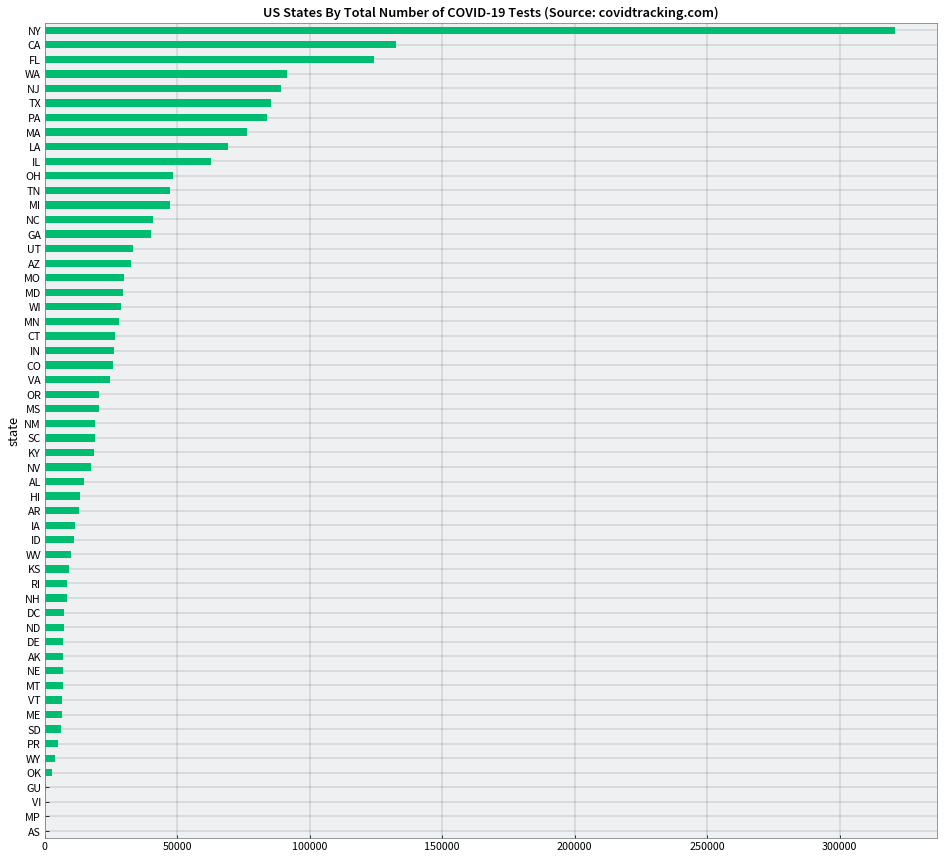

In [34]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [35]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        1.333333
MP        1.400000
VI       17.266667
GU       31.000000
OK      134.200000
WY      231.133333
PR      249.266667
ME      282.266667
SD      350.600000
VT      365.000000
MT      374.200000
AK      394.333333
ND      395.000000
NE      425.533333
DC      426.533333
DE      460.133333
NH      474.466667
RI      497.733333
KS      573.533333
WV      636.200000
ID      651.866667
IA      686.266667
AR      797.933333
AL      877.533333
HI      881.000000
NM      957.133333
NV      999.400000
KY     1146.400000
SC     1154.333333
OR     1173.266667
MS     1269.933333
VA     1412.266667
CO     1414.866667
WI     1493.266667
MN     1563.200000
CT     1572.400000
IN     1646.466667
MD     1951.933333
MO     1958.400000
UT     1980.333333
AZ     2140.000000
NC     2285.866667
GA     2399.466667
TN     2904.866667
MI     2943.133333
OH     3192.466667
IL     3641.466667
WA     4283.600000
LA     4377.866667
MA     4688.266667
TX     5106.733333
PA     5227.400000
NJ    

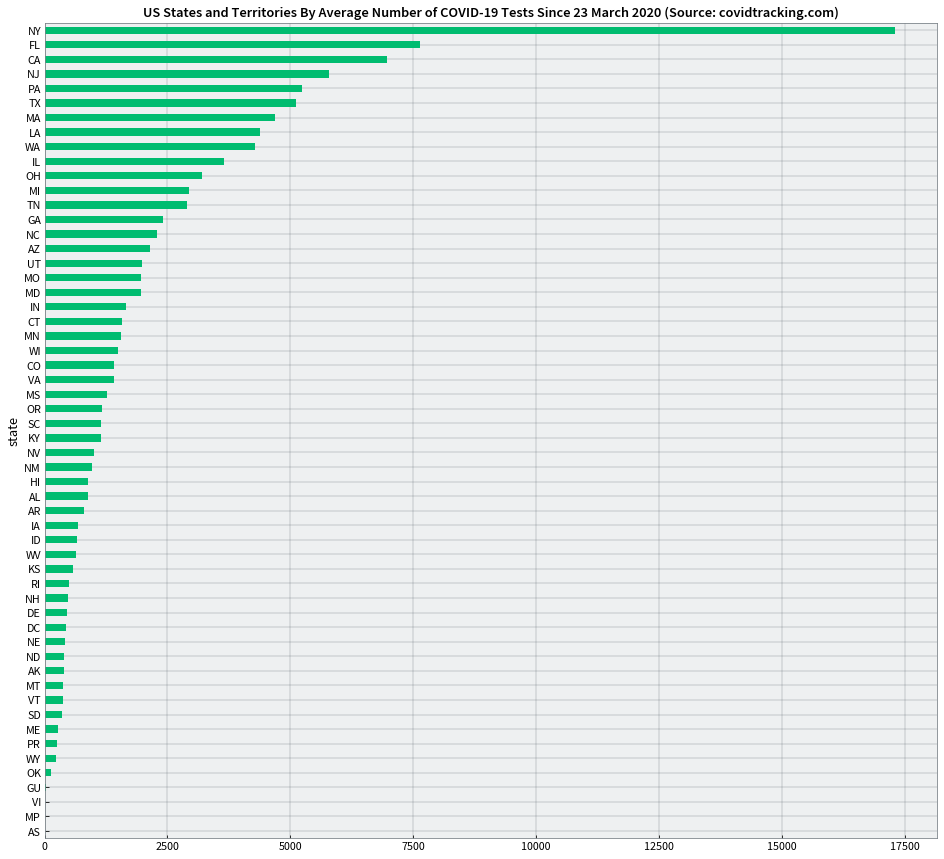

In [36]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [37]:
tests_df.groupby('state')['positive'].max().sort_values()

state
AS         0.0
MP         8.0
VI        43.0
GU       113.0
AK       191.0
WY       210.0
ND       225.0
SD       288.0
MT       299.0
WV       345.0
HI       371.0
NE       409.0
ME       499.0
PR       513.0
VT       543.0
NM       624.0
NH       669.0
DE       673.0
KS       845.0
AR       875.0
IA       946.0
KY       955.0
MN       986.0
OR      1068.0
RI      1082.0
DC      1097.0
ID      1101.0
OK      1327.0
UT      1675.0
MS      1738.0
NV      1953.0
AL      1968.0
SC      2049.0
WI      2440.0
AZ      2456.0
MO      2722.0
NC      2870.0
VA      2878.0
TN      3802.0
MD      4045.0
OH      4450.0
IN      4944.0
CO      4950.0
CT      6906.0
TX      7276.0
GA      7314.0
WA      7984.0
IL     12262.0
PA     12980.0
FL     13324.0
MA     13837.0
CA     14336.0
LA     14867.0
MI     17221.0
NJ     41090.0
NY    130689.0
Name: positive, dtype: float64

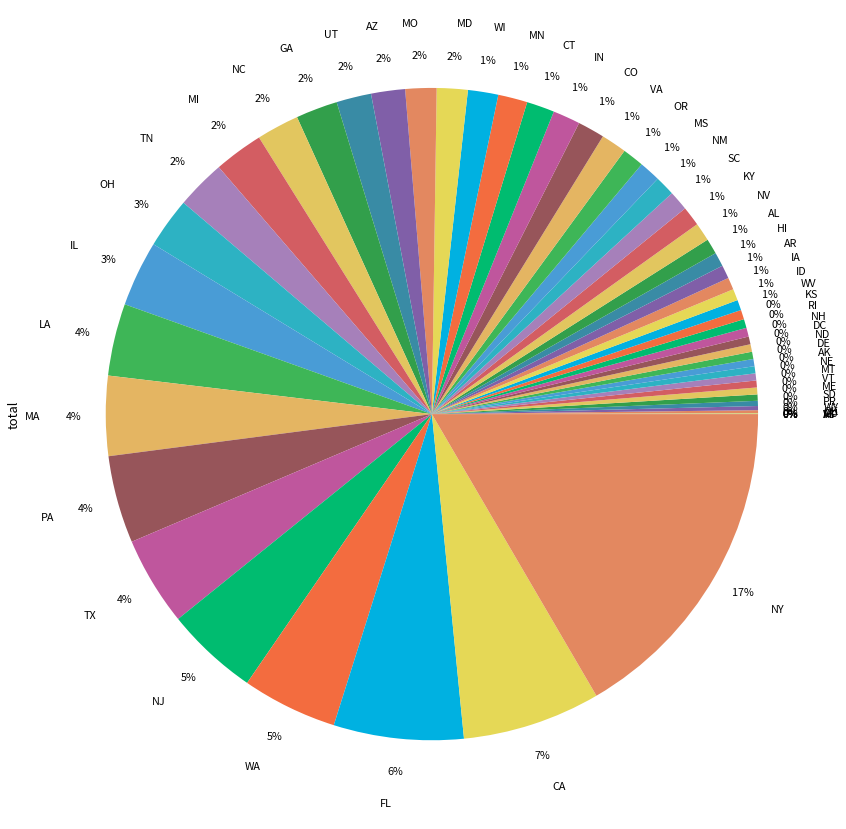

In [38]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

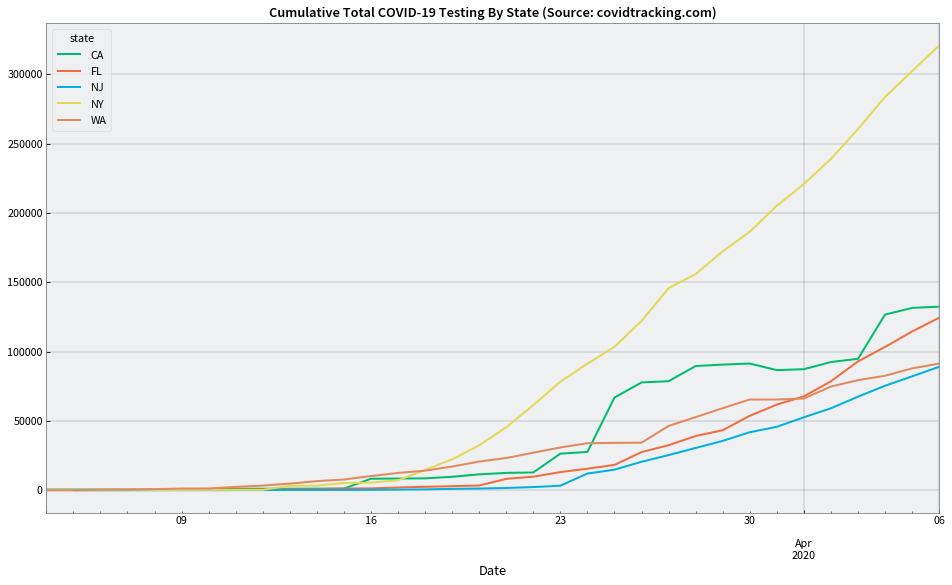

In [39]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

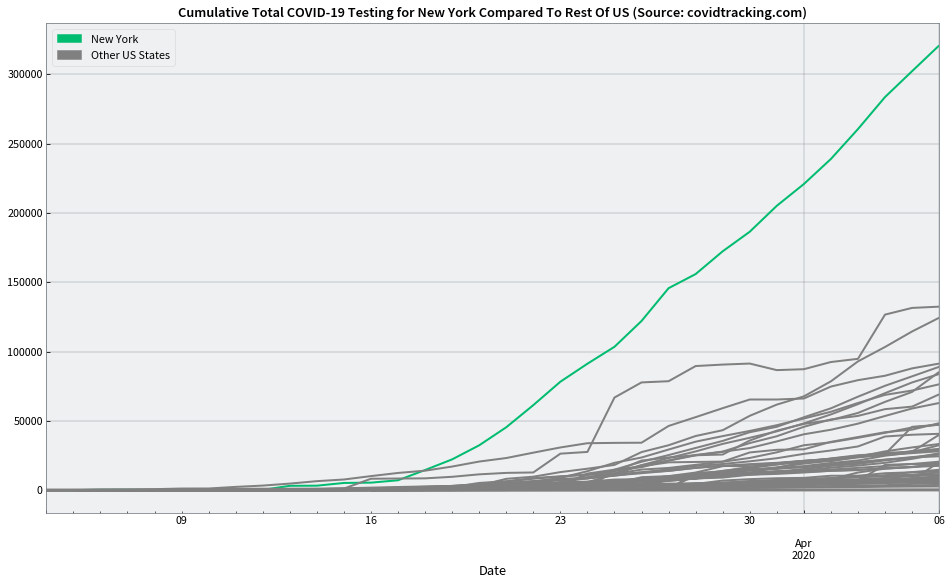

In [40]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

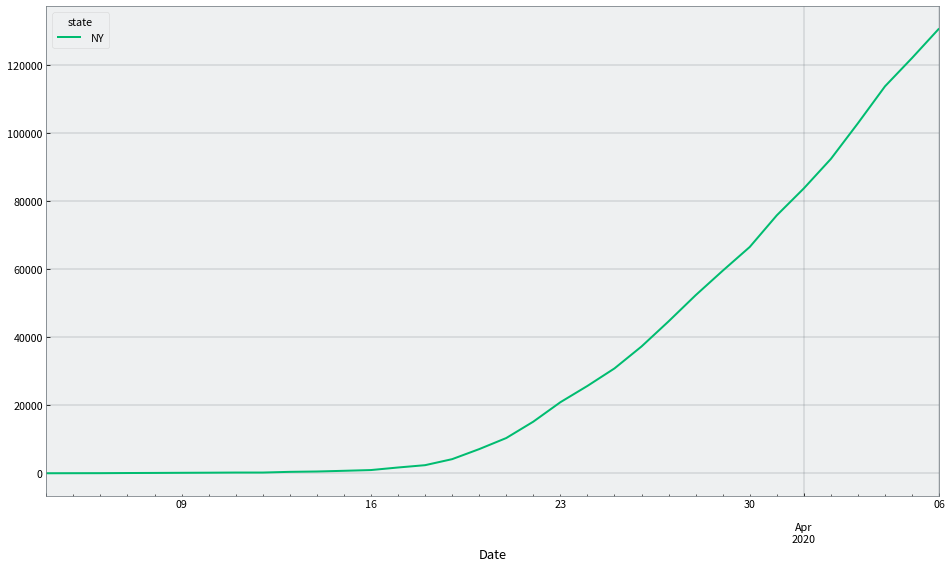

In [41]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [42]:
ny_state_hospitalization['Cumulative Hospitalized'] = 

SyntaxError: invalid syntax (<ipython-input-42-cc48b835a970>, line 1)

In [ ]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

In [ ]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [ ]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

In [ ]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()